In [12]:
# Cell [1]: Import libraries and ensure inline plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plots in Jupyter
%matplotlib inline

print("Libraries imported successfully.")

Libraries imported successfully.


In [13]:
# Cell [2]: Load the dataset from S3
%store -r s3_csv_private_path  

# Construct the full S3 CSV path
s3_csv_path = f"{s3_csv_private_path}/Airline_Delay_Cause.csv.gz"
print("Loading data from:", s3_csv_path)

# Read the CSV file, assuming it is compressed using gzip and has a header row
df = pd.read_csv(s3_csv_path, compression='gzip')

# Print basic information
print("Data shape:", df.shape)
df.head()

Loading data from: s3://sagemaker-us-east-1-607916531205/airline-delay-cause/csv/Airline_Delay_Cause.csv.gz
Data shape: (390637, 19)


,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,9,9E,ABE,81.0,7.0,5.61,0.56,0.84,0.0,0.00,0.0,0.0,243.0,201.0,15.0,27.0,0.0,0.0
1,2024,9,9E,AEX,81.0,6.0,4.43,0.00,1.13,0.0,0.44,0.0,0.0,647.0,440.0,0.0,189.0,0.0,18.0
2,2024,9,9E,AGS,133.0,12.0,3.49,2.04,3.84,0.0,2.63,10.0,0.0,2382.0,1269.0,594.0,167.0,0.0,352.0
3,2024,9,9E,ALB,73.0,4.0,0.82,1.00,0.23,0.0,1.95,0.0,0.0,160.0,28.0,15.0,9.0,0.0,108.0
4,2024,9,9E,ATL,2204.0,280.0,61.70,17.36,88.36,0.0,112.57,40.0,4.0,24383.0,7840.0,2297.0,3690.0,0.0,10556.0


In [14]:
# Cell [3]: Display the first few rows of the dataframe
print(df.head())

   year  month carrier airport  arr_flights  arr_del15  carrier_ct  \
0  2024      9      9E     ABE         81.0        7.0        5.61   
1  2024      9      9E     AEX         81.0        6.0        4.43   
2  2024      9      9E     AGS        133.0       12.0        3.49   
3  2024      9      9E     ALB         73.0        4.0        0.82   
4  2024      9      9E     ATL       2204.0      280.0       61.70   

   weather_ct  nas_ct  security_ct  late_aircraft_ct  arr_cancelled  \
0        0.56    0.84          0.0              0.00            0.0   
1        0.00    1.13          0.0              0.44            0.0   
2        2.04    3.84          0.0              2.63           10.0   
3        1.00    0.23          0.0              1.95            0.0   
4       17.36   88.36          0.0            112.57           40.0   

   arr_diverted  arr_delay  carrier_delay  weather_delay  nas_delay  \
0           0.0      243.0          201.0           15.0       27.0   
1         

In [15]:
# Cell: Create Additional Derived Features

# 1. Delay Ratio (if 'scheduled_duration' column exists)
if 'scheduled_duration' in df.columns:
    df['delay_ratio'] = df['arr_delay'] / df['scheduled_duration']
    print("New feature 'delay_ratio' created.")
else:
    print("Column 'scheduled_duration' not found. Skipping 'delay_ratio' creation.")

# 2. Delay Category: Convert continuous arrival delay into categories
def delay_category(delay):
    if delay <= 5:
        return 'on_time'
    elif delay <= 15:
        return 'minor_delay'
    else:
        return 'severe_delay'

df['delay_category'] = df['arr_delay'].apply(delay_category)
print("New feature 'delay_category' created.")
print(df[['arr_delay', 'delay_category']].head())

# 3. Interaction Feature: Combine carrier and airport codes into a new feature 
df['carrier_airport'] = df['carrier'].astype(str) + "_" + df['airport'].astype(str)
print("New feature 'carrier_airport' created.")
print(df[['carrier', 'airport', 'carrier_airport']].head())

Column 'scheduled_duration' not found. Skipping 'delay_ratio' creation.
New feature 'delay_category' created.
   arr_delay delay_category
0      243.0   severe_delay
1      647.0   severe_delay
2     2382.0   severe_delay
3      160.0   severe_delay
4    24383.0   severe_delay
New feature 'carrier_airport' created.
  carrier airport carrier_airport
0      9E     ABE          9E_ABE
1      9E     AEX          9E_AEX
2      9E     AGS          9E_AGS
3      9E     ALB          9E_ALB
4      9E     ATL          9E_ATL


In [16]:
# Impute missing numeric columns with their median values
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
print("Missing values after imputation:")
print(df[numeric_cols].isnull().sum())

Missing values after imputation:
year                   0
month                  0
arr_flights            0
arr_del15              0
carrier_ct             0
weather_ct             0
nas_ct                 0
security_ct            0
late_aircraft_ct       0
arr_cancelled          0
arr_diverted           0
arr_delay              0
carrier_delay          0
weather_delay          0
nas_delay              0
security_delay         0
late_aircraft_delay    0
dtype: int64


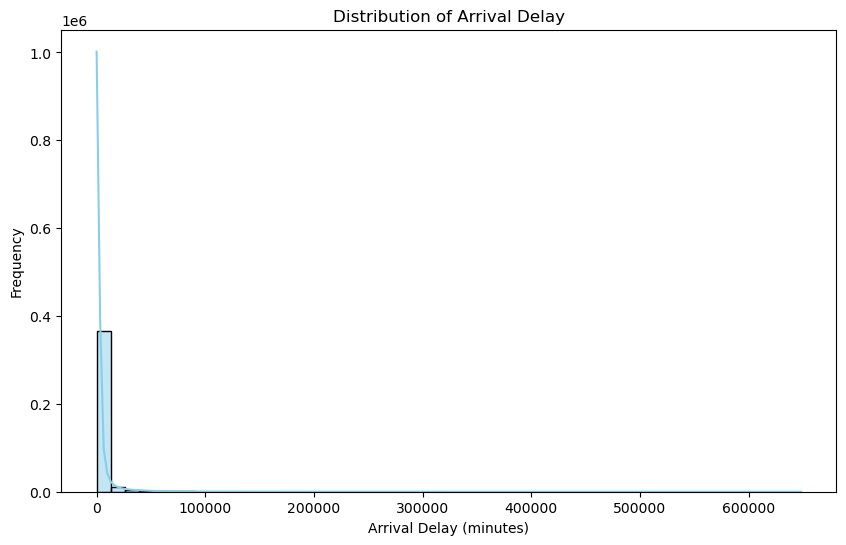

In [17]:
# Cell [6]: Plot a histogram for 'arr_delay'
plt.figure(figsize=(10,6))
sns.histplot(df['arr_delay'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of Arrival Delay')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Frequency')
plt.show()

/tmp/ipykernel_3548/4060960066.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='arr_delay', data=monthly_delay, palette='viridis')


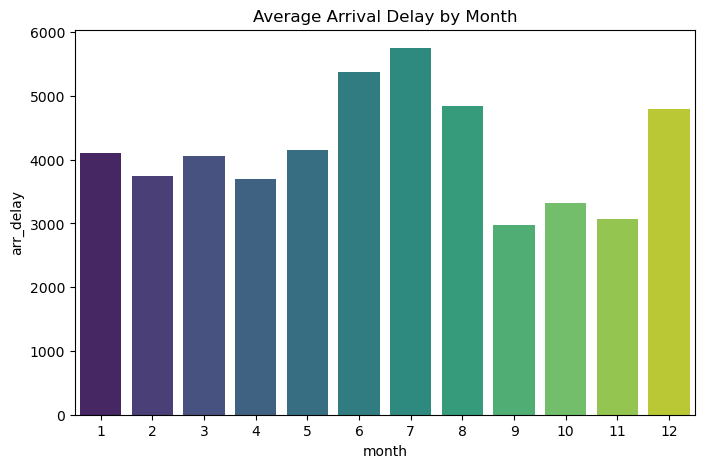

In [19]:
# If you only have year/month, group by month to see monthly trends
monthly_delay = df.groupby('month')['arr_delay'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(x='month', y='arr_delay', data=monthly_delay, palette='viridis')
plt.title("Average Arrival Delay by Month")
plt.show()

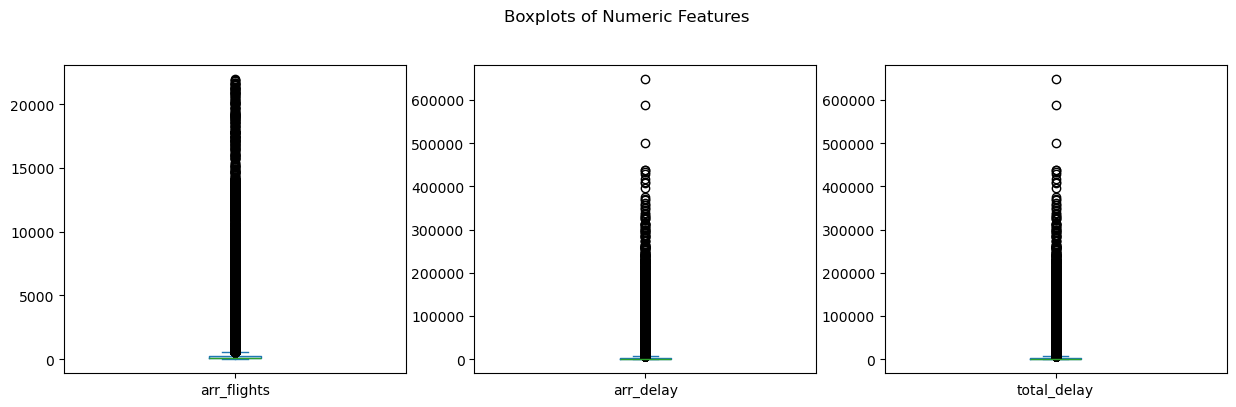

In [22]:
# Boxplots for numeric columns to spot outliers
numeric_cols = ['arr_flights', 'arr_delay', 'total_delay']
df[numeric_cols].plot(kind='box', subplots=True, layout=(1, 3), figsize=(15, 4))
plt.suptitle("Boxplots of Numeric Features", y=1.02)
plt.show()

# Optionally, remove or cap extreme outliers in total_delay
# For instance, capping above 99th percentile:
upper_cap = df['total_delay'].quantile(0.99)
df['total_delay_capped'] = np.where(df['total_delay'] > upper_cap, upper_cap, df['total_delay'])

In [20]:
# Spearman correlation matrix for numeric columns
correlation_matrix_spearman = numeric_df.corr(method='spearman')
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix_spearman, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Spearman Correlation Heatmap (Numeric Features)")
plt.show()

NameError: name 'numeric_df' is not defined

In [10]:
# Compute average total delay grouped by carrier
carrier_delay_summary = df.groupby('carrier')['total_delay'].mean().reset_index()
carrier_delay_summary = carrier_delay_summary.sort_values(by='total_delay', ascending=False)

print("Average Total Delay by Carrier:")
print(carrier_delay_summary.head(10))

Average Total Delay by Carrier:
   carrier   total_delay
33      WN  11471.921630
2       AA   8849.843070
30      UA   6227.757176
6       B6   5780.861360
22      NK   5013.395116
11      DL   4869.301048
31      US   4517.774712
8       CO   4342.163265
34      XE   3953.634414
15      FL   3926.668871


In [25]:
# If you have arr_flights > 0 for each row: 
df['del15_rate'] = df['arr_del15'] / df['arr_flights']
print("New feature 'del15_rate' created (delayed flights ratio).")
df[['arr_flights', 'arr_del15', 'del15_rate']].head()

New feature 'del15_rate' created (delayed flights ratio).


,arr_flights,arr_del15,del15_rate
0,81.0,7.0,0.086420
1,81.0,6.0,0.074074
2,133.0,12.0,0.090226
3,73.0,4.0,0.054795
4,2204.0,280.0,0.127042


In [26]:
# Pivot table showing average total_delay by delay_category and carrier
pivot_df = pd.pivot_table(
    df,
    values='total_delay',
    index='delay_category',
    columns='carrier',
    aggfunc='mean'
)
print("Pivot table for Average total_delay by Delay Category vs Carrier:\n", pivot_df)

Pivot table for Average total_delay by Delay Category vs Carrier:
 carrier                  9E     9K           AA           AQ           AS  \
delay_category                                                              
minor_delay       15.000000    NaN    15.000000          NaN    15.000000   
on_time            0.000000    NaN     0.000000     0.000000     0.000000   
severe_delay    2076.449234  475.4  8942.176991  1045.501992  2196.730275   

carrier                  AX           B6           C5           CO  \
delay_category                                                       
minor_delay       15.000000    15.000000    15.000000    15.000000   
on_time            0.000000     0.000000     0.000000     0.000000   
severe_delay    2100.903675  5860.171213  2239.559441  4528.286706   

carrier                  CP  ...           RU           TZ         UA  \
delay_category               ...                                        
minor_delay       15.000000  ...    15.000000    1

In [9]:
# Cell [8]: Create a new feature 'total_delay' that sums individual delay components
required_columns = ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
if all(col in df.columns for col in required_columns):
    df['total_delay'] = df['carrier_delay'] + df['weather_delay'] + df['nas_delay'] + df['security_delay'] + df['late_aircraft_delay']
    print("New feature 'total_delay' created.")
else:
    print("One or more of the required delay columns are missing.")

# Show the first few rows of delay-related columns including the new feature
print(df[required_columns + ['total_delay']].head())

New feature 'total_delay' created.
   carrier_delay  weather_delay  nas_delay  security_delay  \
0          201.0           15.0       27.0             0.0   
1          440.0            0.0      189.0             0.0   
2         1269.0          594.0      167.0             0.0   
3           28.0           15.0        9.0             0.0   
4         7840.0         2297.0     3690.0             0.0   

   late_aircraft_delay  total_delay  
0                  0.0        243.0  
1                 18.0        647.0  
2                352.0       2382.0  
3                108.0        160.0  
4              10556.0      24383.0  


In [27]:
# Simple frequency encoding example for 'airport'
airport_counts = df['airport'].value_counts()
df['airport_freqenc'] = df['airport'].map(airport_counts)
print(df[['airport', 'airport_freqenc']].head())

  airport  airport_freqenc
0     ABE             1323
1     AEX              643
2     AGS              743
3     ALB             2574
4     ATL             3381


In [28]:
# Cell: Standard Scale Numeric Features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Example of scaling 'total_delay' and 'arr_delay' 
scaled_features = scaler.fit_transform(df[['total_delay', 'arr_delay']])

# Attach scaled versions to your DataFrame
df[['total_delay_scaled', 'arr_delay_scaled']] = scaled_features
df.head()

,year,month,carrier,airport,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,...,security_delay,late_aircraft_delay,total_delay,total_delay_scaled,arr_delay_scaled,delay_category,carrier_airport,total_delay_capped,del15_rate,airport_freqenc
0,2024,9,9E,ABE,81.0,7.0,5.61,0.56,0.84,0.0,...,0.0,0.0,243.0,-0.307757,-0.307758,severe_delay,9E_ABE,243.0,0.086420,1323
1,2024,9,9E,AEX,81.0,6.0,4.43,0.00,1.13,0.0,...,0.0,18.0,647.0,-0.276104,-0.276104,severe_delay,9E_AEX,647.0,0.074074,643
2,2024,9,9E,AGS,133.0,12.0,3.49,2.04,3.84,0.0,...,0.0,352.0,2382.0,-0.140164,-0.140165,severe_delay,9E_AGS,2382.0,0.090226,743
3,2024,9,9E,ALB,73.0,4.0,0.82,1.00,0.23,0.0,...,0.0,108.0,160.0,-0.314261,-0.314261,severe_delay,9E_ALB,160.0,0.054795,2574
4,2024,9,9E,ATL,2204.0,280.0,61.70,17.36,88.36,0.0,...,0.0,10556.0,24383.0,1.583639,1.583638,severe_delay,9E_ATL,24383.0,0.127042,3381


In [14]:
df_encoded = pd.get_dummies(df, columns=['carrier', 'airport'])
print("Encoded columns:", df_encoded.columns)

Encoded columns: Index(['year', 'month', 'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct',
       'nas_ct', 'security_ct', 'late_aircraft_ct', 'arr_cancelled',
       ...
       'airport_VLD', 'airport_VPS', 'airport_WRG', 'airport_WYS',
       'airport_XNA', 'airport_XWA', 'airport_YAK', 'airport_YKM',
       'airport_YNG', 'airport_YUM'],
      dtype='object', length=482)


In [ ]:
from sklearn.model_selection import train_test_split

# Suppose you're predicting a binary outcome (arr_del15?), so choose your feature columns
selected_cols = ['arr_flights', 'arr_delay', 'total_delay', 'del15_rate']  # example
X = df[selected_cols]
y = (df['arr_del15'] >= 1).astype(int)  # example: 1 if there's at least 1 delayed flight ?

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)